In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
print(f"-------------------------------- \n measurements class fields: \n--------------------------------")
for col in Measurement.__table__.columns:
    print(f"column: {col.key}  type: {col.type}")

print(f"-------------------------------- \n stations class fields: \n--------------------------------")
for col in Station.__table__.columns:   
    print(f"column: {col.key}  type: {col.type}")

-------------------------------- 
 measurements class fields: 
--------------------------------
column: id  type: INTEGER
column: station  type: TEXT
column: date  type: TEXT
column: prcp  type: FLOAT
column: tobs  type: FLOAT
-------------------------------- 
 stations class fields: 
--------------------------------
column: id  type: INTEGER
column: station  type: TEXT
column: name  type: TEXT
column: latitude  type: FLOAT
column: longitude  type: FLOAT
column: elevation  type: FLOAT


# Exploratory Climate Analysis

2017-08-23 has type <class 'str'>
2016-08-23 has type <class 'str'>
<class 'list'>
            prcp
date            
2016-08-23  0.00
2016-08-23  0.00
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15


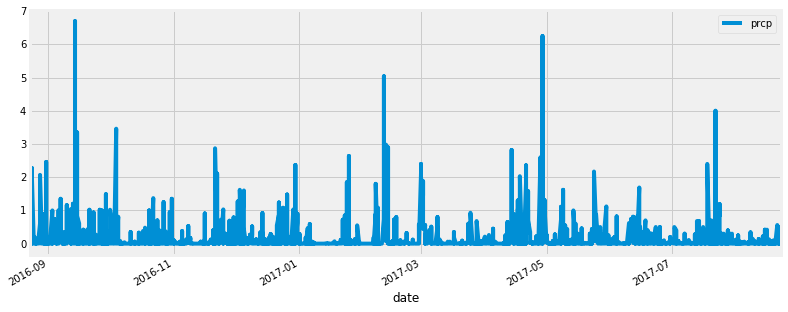

<Figure size 432x288 with 0 Axes>

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# using .limit(1).scalar() to retrieve a single string variable, 
# using .first() returns a sqlalchemy result type object

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()
print(f"{last_date} has type {type(last_date)}")

last_date_one_yr = str(dt.datetime.strptime(last_date, '%Y-%m-%d').date() - dt.timedelta(days=365))
print(f"{last_date_one_yr} has type {type(last_date_one_yr)}")

year_ago_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_date_one_yr).all()

print(type(year_ago_data))

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_dt = pd.DataFrame(year_ago_data)
precip_dt = precip_dt.set_index("date")
precip_dt = precip_dt.fillna(0)
precip_dt.index = pd.to_datetime(precip_dt.index)
precip_dt = precip_dt.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data

print(precip_dt.head())

precip_dt.plot(figsize=(12,5))
plt.show()
plt.savefig('\Images\precipitation.png')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_dt.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).scalar()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
result = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(result)
type(result)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


list

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mactive_station = result[0][0]
print(mactive_station)

result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == mactive_station).all()

print(result)

USC00519281
[(54.0, 85.0, 71.66378066378067)]


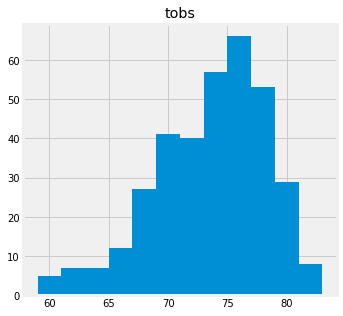

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

result = session.query(Measurement.tobs).filter(Measurement.date >= last_date_one_yr).\
filter(Measurement.station==mactive_station).all()

station_temp_dt = pd.DataFrame(result)
station_temp_dt.head()

station_temp_dt.hist(figsize=(5,5), bins = 12)
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
st_date = "2016-12-15"
end_date = "2017-01-05"

trip_result = calc_temps(st_date, end_date)
trip_result

[(60.0, 70.76811594202898, 78.0)]

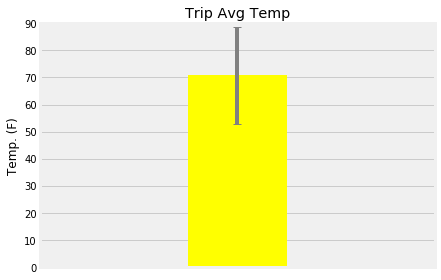

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_result[0][0]
max_temp = trip_result[0][2]
av_temp = trip_result[0][1]
yerr = max_temp - min_temp


plt.bar(0, av_temp, yerr=yerr, align='center', ecolor='gray', capsize=4, color = 'yellow')
plt.title("Trip Avg Temp")
plt.xticks([],[])
plt.tight_layout()
plt.margins(1.5, 1.5)
plt.ylim(0, 90)
plt.ylabel("Temp. (F)")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

result = session.query(Measurement.station, Station.name, Station.latitude,
                       Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
filter(Measurement.date > st_date ).filter(Measurement.date < end_date).group_by(Measurement.station).\
order_by(func.avg(Measurement.prcp).desc()).all()

for x in result:
    print(x)

('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5733333333333338)
('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.159)
('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13949999999999996)
('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08833333333333325)
('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.07249999999999984)
('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.060000000000000005)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0195)


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

st_date_dt = dt.datetime.strptime(st_date, '%Y-%m-%d').date()
end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d').date()

# Use the start and end date to create a range of dates
days = (end_date_dt - st_date_dt).days + 1 #plus one to include 5th of january
date_range = [st_date_dt + dt.timedelta(days=x) for x in range(0,days)]

# Stip off the year and save a list of %m-%d strings
# Had to add additional padding zeroes: 02
month_day = [(date, f"{date.month:02}-{date.day:02}") for date in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [[dm[0],daily_normals(dm[1])] for dm in month_day]

normals_final = [(row[0],row[1][0][0],row[1][0][1],row[1][0][2]) for row in normals]

for normal in normals_final:
    print(normal)

(datetime.date(2016, 12, 15), 62.0, 71.34, 79.0)
(datetime.date(2016, 12, 16), 60.0, 69.62264150943396, 82.0)
(datetime.date(2016, 12, 17), 63.0, 70.64, 77.0)
(datetime.date(2016, 12, 18), 63.0, 71.28, 77.0)
(datetime.date(2016, 12, 19), 67.0, 72.0, 78.0)
(datetime.date(2016, 12, 20), 65.0, 72.91304347826087, 81.0)
(datetime.date(2016, 12, 21), 67.0, 72.13953488372093, 78.0)
(datetime.date(2016, 12, 22), 67.0, 71.1304347826087, 77.0)
(datetime.date(2016, 12, 23), 61.0, 70.34693877551021, 78.0)
(datetime.date(2016, 12, 24), 62.0, 70.0625, 78.0)
(datetime.date(2016, 12, 25), 60.0, 71.75, 79.0)
(datetime.date(2016, 12, 26), 63.0, 71.44680851063829, 77.0)
(datetime.date(2016, 12, 27), 62.0, 71.91666666666667, 79.0)
(datetime.date(2016, 12, 28), 62.0, 70.52083333333333, 77.0)
(datetime.date(2016, 12, 29), 57.0, 70.29166666666667, 78.0)
(datetime.date(2016, 12, 30), 63.0, 69.86363636363636, 76.0)
(datetime.date(2016, 12, 31), 56.0, 68.27906976744185, 77.0)
(datetime.date(2017, 1, 1), 62.0, 6

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_ranges = pd.DataFrame(normals_final, columns = ["date","tmin","tavg","tmax"])
trip_ranges = trip_ranges.set_index("date")
trip_ranges.head()

,tmin,tavg,tmax
date,,,
2016-12-15,62.0,71.340000,79.0
2016-12-16,60.0,69.622642,82.0
2016-12-17,63.0,70.640000,77.0
2016-12-18,63.0,71.280000,77.0
2016-12-19,67.0,72.000000,78.0


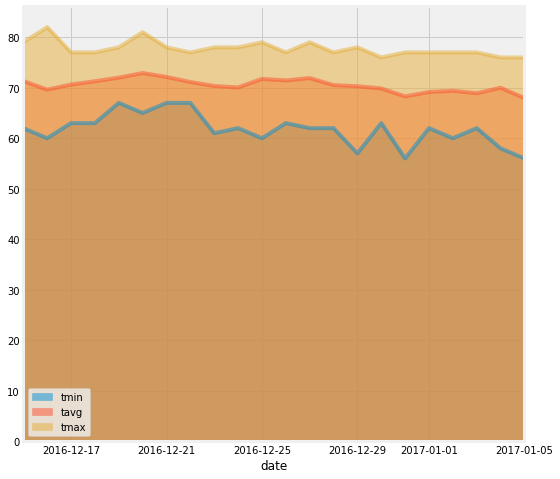

In [24]:
# Plot the daily normals as an area plot with `stacked=False`

trip_ranges.plot.area(x_compat=True, stacked=False, figsize=(8,8))